In [610]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 8
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
import pandas as pd
from sklearn.preprocessing import Imputer
from sklearn.metrics import confusion_matrix
from sklearn.grid_search import GridSearchCV
pd.options.display.max_columns = 100

In [438]:
df=pd.read_csv("parsed_df/parsed_df.csv")

In [531]:
df.head()

,Unnamed: 0,EVENTMSGACTIONTYPE,EVENTMSGTYPE,EVENTNUM,GAME_ID,PERIOD_x,PERSON1TYPE,PERSON2TYPE,PERSON3TYPE,PLAYER2_ID,PLAYER3_ID,SCOREMARGIN,WCTIMESTRING,HOME_TEAM_ID,AWAY_TEAM_ID,HOME_PLAYER1_ID,HOME_PLAYER2_ID,HOME_PLAYER3_ID,HOME_PLAYER4_ID,HOME_PLAYER5_ID,AWAY_PLAYER1_ID,AWAY_PLAYER2_ID,AWAY_PLAYER3_ID,AWAY_PLAYER4_ID,AWAY_PLAYER5_ID,ACTION_BEFORE,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,DRIBBLES,FINAL_MARGIN,LOCATION,PTS,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,SHOT_RESULT,TOUCH_TIME,W,GAME_EVENT_ID,PLAYER_ID,TEAM_ID,ACTION_TYPE,SHOT_ZONE_BASIC,SHOT_ZONE_AREA,SHOT_ZONE_RANGE,SHOT_DISTANCE,LOC_X,LOC_Y,SHOT_MADE_FLAG,off_height,def_height,SEC_LEFT_Q,SEC_LEFT_G
0,0,1,2,2,21300001,1,4,0,0,0,0,0,7:12 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,10,101131,1.6,2,10,1,0,2,6.7,7.4,1,missed,7.8,True,2,2561,1610612754,Jump Shot,In The Paint (Non-RA),Center(C),Less Than 8 ft.,5,-38,45,0,81,79,699,2859
1,1,79,1,5,21300001,1,4,0,0,0,0,2,7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,6,203090,4.1,1,10,1,2,2,16.8,19.3,1,made,3.2,True,5,202331,1610612754,Pullup Jump shot,Mid-Range,Right Side Center(RC),16-24 ft.,19,105,164,1,81,81,690,2850
2,2,1,2,6,21300001,1,5,0,0,0,0,-2,7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,1,202331,4.4,0,-10,0,0,3,13.0,24.5,1,missed,0.7,False,6,201167,1610612753,Jump Shot,Above the Break 3,Center(C),24+ ft.,27,51,266,0,77,81,675,2835
3,3,5,2,8,21300001,1,4,0,5,0,101131,2,7:13 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,4,101131,0.4,0,10,1,0,2,13.8,1.4,2,missed,1.8,True,8,2561,1610612754,Layup Shot,Restricted Area,Center(C),Less Than 8 ft.,2,28,-5,0,81,79,663,2823
4,4,1,1,11,21300001,1,4,4,0,2561,0,5,7:14 PM,1610612754,1610612753,2561,201579,201588,202331,202362,2749,101131,201167,202696,203090,5,2749,5.7,0,10,1,3,3,15.6,25.1,1,made,0.7,True,11,202362,1610612754,Jump Shot,Above the Break 3,Center(C),24+ ft.,26,15,260,1,77,72,651,2811


In [567]:
dftouse=df.copy()
dftouse=dftouse.dropna()
dftouse=dftouse.sample(20000, replace=False)
del dftouse['Unnamed: 0']
del dftouse['EVENTMSGACTIONTYPE']
del dftouse['WCTIMESTRING']
del dftouse['SHOT_RESULT']
del dftouse['ACTION_TYPE']
del dftouse['SHOT_ZONE_BASIC']
del dftouse['SHOT_ZONE_AREA']
del dftouse['SHOT_ZONE_RANGE']
del dftouse['PERSON1TYPE']
del dftouse['TEAM_ID']
del dftouse['GAME_ID']
del dftouse['SHOT_DISTANCE']
del dftouse['HOME_TEAM_ID']
del dftouse['AWAY_TEAM_ID']
del dftouse['HOME_PLAYER1_ID']
del dftouse['HOME_PLAYER2_ID']
del dftouse['HOME_PLAYER3_ID']
del dftouse['HOME_PLAYER4_ID']
del dftouse['HOME_PLAYER5_ID']
del dftouse['AWAY_PLAYER1_ID']
del dftouse['AWAY_PLAYER2_ID']
del dftouse['AWAY_PLAYER3_ID']
del dftouse['AWAY_PLAYER4_ID']
del dftouse['AWAY_PLAYER5_ID']
del dftouse['PTS']
del dftouse['W']
del dftouse['PERSON3TYPE']
del dftouse['CLOSEST_DEFENDER_PLAYER_ID']
del dftouse['PLAYER3_ID']
del dftouse['PLAYER2_ID']
del dftouse['EVENTMSGTYPE']
del dftouse['FINAL_MARGIN']
del dftouse['PERIOD_x']
dftouse.head()

,EVENTNUM,PERSON2TYPE,SCOREMARGIN,ACTION_BEFORE,CLOSE_DEF_DIST,DRIBBLES,LOCATION,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,TOUCH_TIME,GAME_EVENT_ID,PLAYER_ID,LOC_X,LOC_Y,SHOT_MADE_FLAG,off_height,def_height,SEC_LEFT_Q,SEC_LEFT_G
13153,86,0,-7,4,3.0,1,0,2,6.8,5.3,1,4.1,86,201576,-27,39,1,83,83,222,2382
209368,316,0,9,8,3.1,7,1,2,11.1,10.3,9,6.4,316,201950,-48,82,0,76,73,245,965
278790,420,0,-1,4,2.4,5,1,2,11.7,11.2,10,4.1,420,1938,-82,-2,0,78,78,288,288
39881,288,0,6,1,1.6,2,1,2,6.8,9.6,13,3.1,288,203089,-54,31,0,83,81,305,1025
227839,265,0,11,4,5.5,3,1,2,10.4,24.4,5,6.3,265,101107,-127,178,0,81,83,686,1406


In [568]:
#drop all rows with NaN values
dftouse = dftouse.dropna()
dftouse.shape

(20000, 21)

In [569]:
cols = list(dftouse)
cols.insert(0, cols.pop(cols.index('SHOT_MADE_FLAG')))
dftouse = dftouse.ix[:, cols]
dftouse.head()

,SHOT_MADE_FLAG,EVENTNUM,PERSON2TYPE,SCOREMARGIN,ACTION_BEFORE,CLOSE_DEF_DIST,DRIBBLES,LOCATION,PTS_TYPE,SHOT_CLOCK,SHOT_DIST,SHOT_NUMBER,TOUCH_TIME,GAME_EVENT_ID,PLAYER_ID,LOC_X,LOC_Y,off_height,def_height,SEC_LEFT_Q,SEC_LEFT_G
13153,1,86,0,-7,4,3.0,1,0,2,6.8,5.3,1,4.1,86,201576,-27,39,83,83,222,2382
209368,0,316,0,9,8,3.1,7,1,2,11.1,10.3,9,6.4,316,201950,-48,82,76,73,245,965
278790,0,420,0,-1,4,2.4,5,1,2,11.7,11.2,10,4.1,420,1938,-82,-2,78,78,288,288
39881,0,288,0,6,1,1.6,2,1,2,6.8,9.6,13,3.1,288,203089,-54,31,83,81,305,1025
227839,0,265,0,11,4,5.5,3,1,2,10.4,24.4,5,6.3,265,101107,-127,178,81,83,686,1406


In [513]:
dftouse.shape

(20000, 22)

In [570]:
#dftouse.isnull().sum()

In [515]:
#dftouse.isnull().any()

In [571]:
Xnames = list(dftouse.columns.values[1:22])

In [578]:
Xnames

['EVENTNUM',
 'SCOREMARGIN',
 'ACTION_BEFORE',
 'CLOSE_DEF_DIST',
 'DRIBBLES',
 'LOCATION',
 'PTS_TYPE',
 'SHOT_CLOCK',
 'SHOT_DIST',
 'SHOT_NUMBER',
 'TOUCH_TIME',
 'GAME_EVENT_ID',
 'PLAYER_ID',
 'LOC_X',
 'LOC_Y',
 'off_height',
 'def_height',
 'SEC_LEFT_Q',
 'SEC_LEFT_G']

In [643]:
removes = ["PERSON2TYPE", "PLAYER_ID"]
for r in removes:
    try:
        Xnames.remove(r)
    except ValueError:
        pass

In [644]:
#create train and test set
from sklearn.cross_validation import train_test_split
itrain, itest = train_test_split(xrange(dftouse.shape[0]), train_size=0.7)
mask=np.ones(dftouse.shape[0], dtype='int')
mask[itrain]=1
mask[itest]=0
mask = (mask==1)

In [645]:
dftouse.shape[0]

20000

In [646]:
import sklearn
from sklearn.svm import LinearSVC
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import Ridge
from sklearn.grid_search import GridSearchCV

def cv_optimize(clf, parameters, X, y, n_jobs=1, n_folds=5, score_func=None):
    if score_func:
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print "BEST", gs.best_params_, gs.best_score_, gs.grid_scores_
    best = gs.best_estimator_
    return best

def do_classify(clf, parameters, indf, featurenames, targetname, target1val, mask=None, reuse_split=None, score_func=None, n_folds=5, n_jobs=1):
    subdf=indf[featurenames]
    X=subdf.values
    y=(indf[targetname].values==target1val)*1
    y_=indf[targetname]
    if mask !=None:
        print "using mask"
        Xtrain, Xtest, ytrain, ytest = X[mask], X[~mask], y[mask], y[~mask]
    if reuse_split !=None:
        print "using reuse split"
        Xtrain, Xtest, ytrain, ytest = reuse_split['Xtrain'], reuse_split['Xtest'], reuse_split['ytrain'], reuse_split['ytest']
    if parameters:
        clf = cv_optimize(clf, parameters, Xtrain, ytrain, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "############# based on standard predict ################"
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    print confusion_matrix(ytest, clf.predict(Xtest))
    print "########################################################"
    return clf, Xtrain, ytrain, Xtest, ytest

In [651]:
%%time
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics

clfForest = RandomForestClassifier()

parameters = {
    "n_estimators" : [10,50,100,500],
    #"n_estimators" : range(1, 21),
#    "max_features" : range(10,len(Xnames+1),2)
    "max_depth": [50,100,200,400],
#    "bootstrap": [True, False]
}
clfForest, Xtrain, ytrain, Xtest, ytest = do_classify(clfForest, parameters, dftouse, Xnames, 'SHOT_MADE_FLAG', 1, mask=mask, n_folds = 5, n_jobs = 4, score_func='f1')

using mask


/Users/raymondcen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:23: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.


BEST {'n_estimators': 500, 'max_depth': 100} 0.522559263743 [mean: 0.49173, std: 0.01649, params: {'n_estimators': 10, 'max_depth': 50}, mean: 0.50816, std: 0.00425, params: {'n_estimators': 50, 'max_depth': 50}, mean: 0.51837, std: 0.01274, params: {'n_estimators': 100, 'max_depth': 50}, mean: 0.51873, std: 0.01537, params: {'n_estimators': 500, 'max_depth': 50}, mean: 0.48616, std: 0.00554, params: {'n_estimators': 10, 'max_depth': 100}, mean: 0.51454, std: 0.01254, params: {'n_estimators': 50, 'max_depth': 100}, mean: 0.52063, std: 0.01244, params: {'n_estimators': 100, 'max_depth': 100}, mean: 0.52256, std: 0.01084, params: {'n_estimators': 500, 'max_depth': 100}, mean: 0.48395, std: 0.01105, params: {'n_estimators': 10, 'max_depth': 200}, mean: 0.51065, std: 0.00834, params: {'n_estimators': 50, 'max_depth': 200}, mean: 0.51481, std: 0.01380, params: {'n_estimators': 100, 'max_depth': 200}, mean: 0.51709, std: 0.01420, params: {'n_estimators': 500, 'max_depth': 200}, mean: 0.48598

In [652]:
name_list

('PTS_TYPE',
 'LOCATION',
 'DRIBBLES',
 'ACTION_BEFORE',
 'SHOT_NUMBER',
 'off_height',
 'def_height',
 'GAME_EVENT_ID',
 'EVENTNUM',
 'TOUCH_TIME',
 'SEC_LEFT_G',
 'SEC_LEFT_Q',
 'SCOREMARGIN',
 'CLOSE_DEF_DIST',
 'SHOT_CLOCK',
 'LOC_X',
 'LOC_Y',
 'SHOT_DIST')

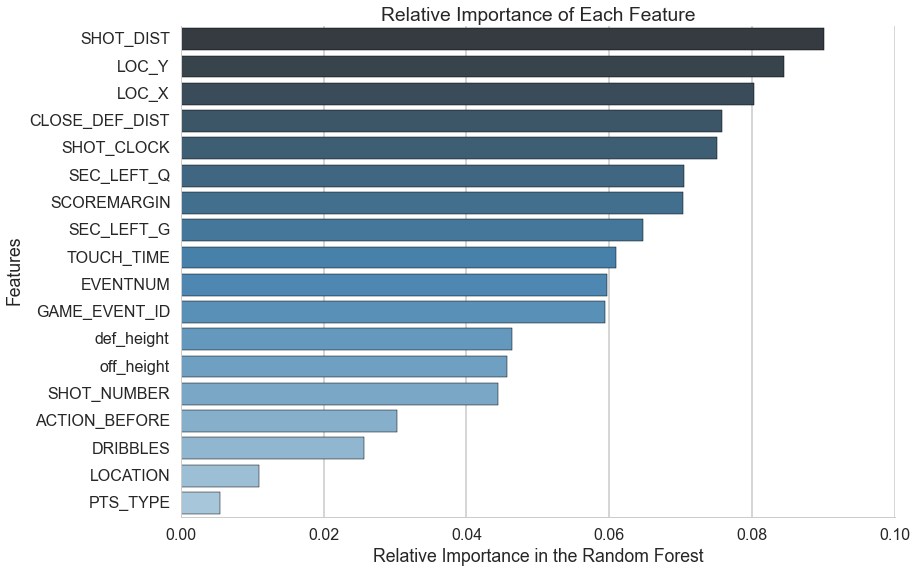

In [653]:
importance_list = clfForest.feature_importances_
name_list = dftouse.columns
importance_list, name_list = zip(*sorted(zip(importance_list, Xnames)))
ax = sns.barplot(y=range(len(name_list)),x=list(reversed(importance_list)), orient='h', palette="Blues_d")
ax.set_xlabel('Relative Importance in the Random Forest')
ax.set_ylabel('Features')
ax.set_title('Relative Importance of Each Feature')
ax.set_yticklabels(list(reversed(name_list)));
sns.despine()
plt.savefig('Baseline Relative Importance.png')